### MODEL CHECKPOINT WILCOXON SIGNED-RANK TEST

In this Notebook, Wilcoxon Signed-Rank Test is performed on the weights and biases of all the layers of the two models across all four checkpoints resepctively. This is an attempt to see if there are any median difference similarities in the weights and biases of the two models on a per layer and a per checkpoint bases. 

##### LOADING NECESSARY LIBRARIES AND CREATING NECESSARY FUNCTIONS

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import custom_vgg22
import preloaded_vgg22
import os
import matplotlib.patches as mpatches

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
# function to load preloaded VGGNet model on custom VGGNet model architecture
def model_preload(weights=tf.keras.Model.weights):
    """
    input:
    weights -- weights of the base VGGNet model

    output:
    tf.keras.Model -- VGG22 Model with preloaded_VGG weights but custom_VGG architecture
    
    """
    # purpose of this function is to make later weights and biases comparisons easier
    # by providing the same architecture to both the models
    
    base_model = preloaded_vgg22.cifar10_VGG22()   # loading preloaded VGG22 model
    base_model.load_weights(weights)
    
    preload_model = custom_vgg22.cifar10_custom_VGG22()  # loading custom VGG22 model

    i = 2
    # assigning weights correspondingly from preloaded model to custom model
    for layer in base_model.layers[3].layers:
        preload_model.layers[i].set_weights(layer.weights)  # VGGNet architecture
        i += 1
    
    preload_model.layers[i].set_weights(base_model.layers[4].weights)       # batchnormalization layer
    preload_model.layers[i+3].set_weights(base_model.layers[7].weights)     # fc1 dense layer
    preload_model.layers[i+5].set_weights(base_model.layers[9].weights)     # fc2 dense layer
    preload_model.layers[i+7].set_weights(base_model.layers[11].weights)    # fc3 dense layer
    preload_model.layers[i+9].set_weights(base_model.layers[13].weights)    # fc4 dense layer
    preload_model.layers[i+11].set_weights(base_model.layers[15].weights)   # predictions layer

    return preload_model

In [4]:
# function to perform Wilcoxon Signed-Rank Test across the two models for respective layer weights and biases
def wilcoxon_calc(models=[tf.keras.Model, tf.keras.Model]):
    """
    input:
    models -- two tf.keras.Model

    output:
    dictionary -- a dictionary with Wilcoxon Signed-Rank Test results
    """
    data = {}

    for i in range(len(models[0].layers)):  # looping through the model     
        if models[0].layers[i].weights != []:  # excluding layers without weights and biases
            model1_weights = models[0].layers[i].get_weights()[0].flatten()
            model1_biases = models[0].layers[i].get_weights()[1]
            model2_weights = models[1].layers[i].get_weights()[0].flatten()
            model2_biases = models[1].layers[i].get_weights()[1]
            # performing Wilcoxon Signed-Rank Test
            if np.all(model2_weights - model1_weights != 0.0):  # making sure element-wise subtraction doesn't result in 0
                _, data[models[0].layers[i].name+"_w"] = stats.wilcoxon(model1_weights, model2_weights)
            if np.all(model2_biases - model1_biases != 0.0):  # making sure element-wise subtraction doesn't result in 0
                _, data[models[0].layers[i].name+"_b"] = stats.wilcoxon(model1_biases, model2_biases)
            
    return data

In [5]:
# function to transform dictionary to Pandas DataFrame
def dict_to_DF(g_dict=None, checkpoint=None):
    """
    input:
    g_dict -- a dictionary with Wilcoxon Signed-Rank Test results
    checkpoint -- model checkpoint as a string
    
    output:
    Pandas DataFrame -- a Pandas DataFrame
    
    """
    data = pd.DataFrame(list(g_dict.items()), columns=['Layer', 'p-Value'])  # creating DataFrame
    # creating a column to tell if H0 is rejected or not
    data["Difference in Layer Weights"] = data['p-Value'].apply(lambda x: "Not significant (H0 rejection fail)" if x > 0.05 else "Significant (reject H0)")
    # creating a column with binary encoded median difference values
    data["binary difference"] = data['p-Value'].apply(lambda x: 0 if x > 0.05 else 1)
    # creating a column with checkpoint values
    data["checkpoint"] = checkpoint
    # creating a column to spot weights or biases
    data["value category"] = data["Layer"].apply(lambda x: "Weights" if x.rsplit("_", 1)[-1] == "w" else "Biases")
    # fixing up the Layer column
    data["Layer"] = data["Layer"].apply(lambda x: x.rsplit("_", 1)[0])
    
    return data

### CHECKPOINT 1

In [6]:
# loading both models with respective initial weights
custom_model = custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_1.h5')
preload_model = model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_1.h5')

In [7]:
# performing the test across the respective layers of the two models
wilcoxon_data = wilcoxon_calc(models = [preload_model, custom_model])

In [8]:
# putting together the calculations into a Pandas DataFrame
wilcoxon_df = dict_to_DF(g_dict=wilcoxon_data, checkpoint="Checkpoint 1")
wilcoxon_df.iloc[:,:3].head()

,Layer,p-Value,Difference in Layer Weights
0,block1_conv1,5.170086e-01,Not significant (H0 rejection fail)
1,block1_conv1,3.696686e-12,Significant (reject H0)
2,block1_conv2,1.812326e-21,Significant (reject H0)
3,block1_conv2,3.515539e-02,Significant (reject H0)
4,block2_conv1,3.062550e-02,Significant (reject H0)


In [9]:
# putting together a new Pandas DataFrame to combine results from all checkpoints
overall_wilcoxon_data = wilcoxon_df

### CHECKPOINT 2

In [10]:
# loading both models with respective initial weights
custom_model = custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_2.h5')
preload_model = model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_2.h5')

In [11]:
# performing the test across the respective layers of the two models
wilcoxon_data = wilcoxon_calc(models = [preload_model, custom_model])

In [12]:
# putting together the calculations into a Pandas DataFrame
wilcoxon_df = dict_to_DF(g_dict=wilcoxon_data, checkpoint="Checkpoint 2")
wilcoxon_df.iloc[:,:3].head()

,Layer,p-Value,Difference in Layer Weights
0,block1_conv1,7.292619e-01,Not significant (H0 rejection fail)
1,block1_conv1,4.063868e-12,Significant (reject H0)
2,block1_conv2,1.211458e-93,Significant (reject H0)
3,block1_conv2,4.554737e-02,Significant (reject H0)
4,block2_conv1,7.306996e-15,Significant (reject H0)


In [13]:
# putting checkpoint 2 results into a combined results DataFrame
overall_wilcoxon_data = pd.concat([overall_wilcoxon_data, wilcoxon_df], ignore_index=True)

### CHECKPOINT 3

In [14]:
# loading both models with respective initial weights
custom_model = custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_3.h5')
preload_model = model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_3.h5')

In [15]:
# performing the test across the respective layers of the two models
wilcoxon_data = wilcoxon_calc(models = [preload_model, custom_model])

In [16]:
# putting together the calculations into a Pandas DataFrame
wilcoxon_df = dict_to_DF(g_dict=wilcoxon_data, checkpoint="Checkpoint 3")
wilcoxon_df.iloc[:,:3].head()

,Layer,p-Value,Difference in Layer Weights
0,block1_conv1,5.931358e-01,Not significant (H0 rejection fail)
1,block1_conv1,4.260636e-12,Significant (reject H0)
2,block1_conv2,1.036366e-60,Significant (reject H0)
3,block1_conv2,5.245553e-02,Not significant (H0 rejection fail)
4,block2_conv1,4.998691e-01,Not significant (H0 rejection fail)


In [17]:
# putting checkpoint 3 results into a combined results DataFrame
overall_wilcoxon_data = pd.concat([overall_wilcoxon_data, wilcoxon_df], ignore_index=True)

### CHECKPOINT 4

In [18]:
# loading both models with respective initial weights
custom_model = custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_4.h5')
preload_model = model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_4.h5')

In [19]:
# performing the test across the respective layers of the two models
wilcoxon_data = wilcoxon_calc(models = [preload_model, custom_model])

In [20]:
# putting together the calculations into a Pandas DataFrame
wilcoxon_df = dict_to_DF(g_dict=wilcoxon_data, checkpoint="Checkpoint 4")
wilcoxon_df.iloc[:,:3].head()

,Layer,p-Value,Difference in Layer Weights
0,block1_conv1,6.339583e-01,Not significant (H0 rejection fail)
1,block1_conv1,4.466736e-12,Significant (reject H0)
2,block1_conv2,2.761667e-48,Significant (reject H0)
3,block1_conv2,5.164707e-02,Not significant (H0 rejection fail)
4,block2_conv1,9.444220e-01,Not significant (H0 rejection fail)


In [21]:
# putting checkpoint 4 results into a combined results DataFrame
overall_wilcoxon_data = pd.concat([overall_wilcoxon_data, wilcoxon_df], ignore_index=True)

### TEST RESULTS VISULAIZATION

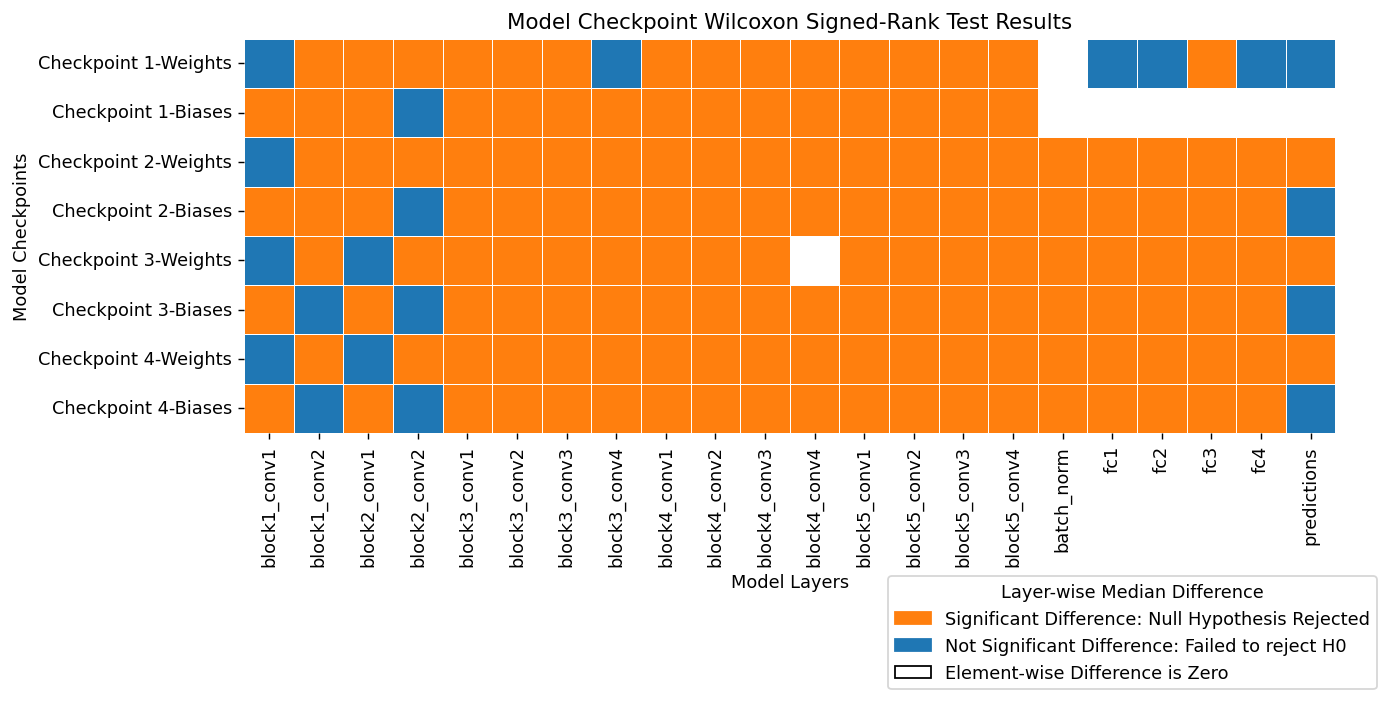

In [22]:
# Wilcoxon Signed-Rank Test Results Data Visualization
data = overall_wilcoxon_data.pivot(index="Layer", columns=["checkpoint", "value category"], values="binary difference")
data = data.reindex(overall_wilcoxon_data["Layer"][38:].unique())

plt.figure(figsize=(11, 4), dpi=128)

sns.heatmap(data.T, cbar=False, cmap=sns.color_palette(n_colors=2), linewidths=0.5)

significant_patch = mpatches.Patch(color=sns.color_palette(as_cmap=True)[1], label='Significant Difference: Null Hypothesis Rejected')
not_significant_patch = mpatches.Patch(color=sns.color_palette(as_cmap=True)[0], label='Not Significant Difference: Failed to reject H0')
missing_data_patch = mpatches.Patch(facecolor="white", edgecolor="black", label="Element-wise Difference is Zero")
plt.legend(handles=[significant_patch, not_significant_patch, missing_data_patch], loc=(0.59,-0.65), title='Layer-wise Median Difference')

plt.xlabel('Model Layers')
plt.ylabel('Model Checkpoints')
plt.title('Model Checkpoint Wilcoxon Signed-Rank Test Results')

plt.show()